## Imports

In [15]:
import numpy as np
import pandas as pd
import networkx as nx
from scipy.stats import truncexpon, halfnorm, bernoulli
import json

## Helpers

In [16]:
import numpy as np
import pandas as pd
from scipy.stats import truncexpon, halfnorm, bernoulli

def create_observed_data(unobserved_intrinsic_metrics):
    observed_metrics = {}
    num_samples = len(unobserved_intrinsic_metrics['Product DB']['latency'])

    # Initialize observed metrics for each component
    components = ['Product DB', 'Customer DB', 'Order DB', 'Shipping Cost Service',
                  'Caching Service', 'Product Service', 'Auth Service', 'Order Service',
                  'API', 'www', 'Website']
    for comp in components:
        observed_metrics[comp] = {
            'latency': np.zeros(num_samples),
            'request_rate': np.zeros(num_samples),
            'error_rate': np.zeros(num_samples)
        }

    # Simulate metrics for databases
    for db in ['Product DB', 'Customer DB', 'Order DB']:
        observed_metrics[db]['latency'] = unobserved_intrinsic_metrics[db]['latency']
        observed_metrics[db]['request_rate'] = unobserved_intrinsic_metrics[db]['request_rate']
        observed_metrics[db]['error_rate'] = unobserved_intrinsic_metrics[db]['error_rate']

    # Simulate metrics for Shipping Cost Service
    observed_metrics['Shipping Cost Service']['latency'] = unobserved_intrinsic_metrics['Shipping Cost Service']['latency']
    observed_metrics['Shipping Cost Service']['request_rate'] = unobserved_intrinsic_metrics['Shipping Cost Service']['request_rate']
    observed_metrics['Shipping Cost Service']['error_rate'] = unobserved_intrinsic_metrics['Shipping Cost Service']['error_rate']

    # Simulate metrics for Caching Service
    cache_hit = bernoulli.rvs(0.5, size=num_samples)
    observed_metrics['Caching Service']['latency'] = cache_hit * observed_metrics['Product DB']['latency'] + unobserved_intrinsic_metrics['Caching Service']['latency']
    observed_metrics['Caching Service']['request_rate'] = observed_metrics['Product DB']['request_rate']
    observed_metrics['Caching Service']['error_rate'] = (
        cache_hit * observed_metrics['Product DB']['error_rate'] +
        (1 - cache_hit) * unobserved_intrinsic_metrics['Caching Service']['error_rate']
    )

    # Simulate metrics for Product Service
    max_latency = np.maximum.reduce([
        observed_metrics['Shipping Cost Service']['latency'],
        observed_metrics['Caching Service']['latency'],
        observed_metrics['Customer DB']['latency']
    ])
    observed_metrics['Product Service']['latency'] = max_latency + unobserved_intrinsic_metrics['Product Service']['latency']
    observed_metrics['Product Service']['request_rate'] = observed_metrics['Customer DB']['request_rate']

    # Error rate propagation for Product Service
    upstream_errors = 1 - (
        (1 - observed_metrics['Shipping Cost Service']['error_rate']) *
        (1 - observed_metrics['Caching Service']['error_rate']) *
        (1 - observed_metrics['Customer DB']['error_rate'])
    )
    observed_metrics['Product Service']['error_rate'] = np.maximum(upstream_errors, unobserved_intrinsic_metrics['Product Service']['error_rate'])

    # Simulate metrics for Auth Service
    observed_metrics['Auth Service']['latency'] = observed_metrics['Customer DB']['latency'] + unobserved_intrinsic_metrics['Auth Service']['latency']
    observed_metrics['Auth Service']['request_rate'] = observed_metrics['Customer DB']['request_rate']

    # Error rate propagation for Auth Service
    observed_metrics['Auth Service']['error_rate'] = np.maximum(
        observed_metrics['Customer DB']['error_rate'],
        unobserved_intrinsic_metrics['Auth Service']['error_rate']
    )

    # Simulate metrics for Order Service
    observed_metrics['Order Service']['latency'] = observed_metrics['Order DB']['latency'] + unobserved_intrinsic_metrics['Order Service']['latency']
    observed_metrics['Order Service']['request_rate'] = observed_metrics['Order DB']['request_rate']

    # Error rate propagation for Order Service
    observed_metrics['Order Service']['error_rate'] = np.maximum(
        observed_metrics['Order DB']['error_rate'],
        unobserved_intrinsic_metrics['Order Service']['error_rate']
    )

    # Simulate metrics for API
    observed_metrics['API']['latency'] = (
        observed_metrics['Product Service']['latency'] +
        observed_metrics['Auth Service']['latency'] +
        observed_metrics['Order Service']['latency'] +
        unobserved_intrinsic_metrics['API']['latency']
    )
    observed_metrics['API']['request_rate'] = observed_metrics['Product Service']['request_rate']

    # Error rate propagation for API
    upstream_errors = 1 - (
        (1 - observed_metrics['Product Service']['error_rate']) *
        (1 - observed_metrics['Auth Service']['error_rate']) *
        (1 - observed_metrics['Order Service']['error_rate'])
    )
    observed_metrics['API']['error_rate'] = np.maximum(upstream_errors, unobserved_intrinsic_metrics['API']['error_rate'])

    # Simulate metrics for www
    observed_metrics['www']['latency'] = (
        observed_metrics['API']['latency'] +
        unobserved_intrinsic_metrics['www']['latency']
    )
    observed_metrics['www']['request_rate'] = observed_metrics['API']['request_rate']

    # Error rate propagation for www
    observed_metrics['www']['error_rate'] = np.maximum(
        observed_metrics['API']['error_rate'],
        unobserved_intrinsic_metrics['www']['error_rate']
    )

    # Simulate metrics for Website
    observed_metrics['Website']['latency'] = (
        observed_metrics['www']['latency'] +
        unobserved_intrinsic_metrics['Website']['latency']
    )
    observed_metrics['Website']['request_rate'] = observed_metrics['www']['request_rate']

    # Error rate propagation for Website
    observed_metrics['Website']['error_rate'] = np.maximum(
        observed_metrics['www']['error_rate'],
        unobserved_intrinsic_metrics['Website']['error_rate']
    )

    # Create the DataFrame in the desired format
    data_rows = []

    for time_index in range(num_samples):
        for comp in components:
            data_row = {
                'time_index': time_index,
                'service': comp,
                'rate': observed_metrics[comp]['request_rate'][time_index],
                'error_rate': observed_metrics[comp]['error_rate'][time_index],
                'duration': observed_metrics[comp]['latency'][time_index]
            }
            data_rows.append(data_row)

    df = pd.DataFrame(data_rows)
    return df

def unobserved_intrinsic_metrics_normal(num_samples):
    metrics = {}
    components = ['Website', 'www', 'API', 'Auth Service', 'Product Service', 'Order Service',
                  'Shipping Cost Service', 'Caching Service', 'Order DB', 'Customer DB', 'Product DB']
    for comp in components:
        metrics[comp] = {}
        # Latency
        if comp in ['Website', 'www']:
            metrics[comp]['latency'] = truncexpon.rvs(b=3, scale=0.2, size=num_samples)
        elif comp == 'API':
            metrics[comp]['latency'] = halfnorm.rvs(loc=0.5, scale=0.2, size=num_samples)
        elif comp in ['Auth Service', 'Product Service', 'Shipping Cost Service', 'Caching Service']:
            metrics[comp]['latency'] = halfnorm.rvs(loc=0.1, scale=0.2, size=num_samples)
        elif comp == 'Order Service':
            metrics[comp]['latency'] = halfnorm.rvs(loc=0.5, scale=0.2, size=num_samples)
        elif comp in ['Order DB', 'Customer DB', 'Product DB']:
            metrics[comp]['latency'] = truncexpon.rvs(b=5, scale=0.2, size=num_samples)
        else:
            metrics[comp]['latency'] = halfnorm.rvs(loc=0.1, scale=0.2, size=num_samples)

        # Request Rate
        if comp == 'Website':
            metrics[comp]['request_rate'] = np.random.poisson(lam=1000, size=num_samples)
        elif comp in ['www', 'API']:
            metrics[comp]['request_rate'] = np.random.poisson(lam=950, size=num_samples)
        else:
            metrics[comp]['request_rate'] = np.random.poisson(lam=900, size=num_samples)

        # Error Rate
        metrics[comp]['error_rate'] = np.random.beta(a=1, b=100, size=num_samples)

    return metrics

def unobserved_intrinsic_metrics_anomalous(num_samples):
    metrics = unobserved_intrinsic_metrics_normal(num_samples)

    # Introduce anomaly in Caching Service
    metrics['Caching Service']['latency'] = 2 + halfnorm.rvs(loc=0.1, scale=0.1, size=num_samples)
    metrics['Caching Service']['error_rate'] = np.random.beta(a=10, b=90, size=num_samples)  # Higher error rate

    return metrics

In [17]:
# Plot bar charts comparing normal and anomalous data for each metric
import matplotlib.pyplot as plt

def plot_normal_vs_anomalous_metrics(normal_data, amomalous_data):
    aggs_norm = normal_data.groupby('service').agg({
        'rate': 'mean',
        'error_rate': 'mean',
        'duration': 'mean'
    })

    aggs_anom = anomalous_data.groupby('service').agg({
        'rate': 'mean',
        'error_rate': 'mean',
        'duration': 'mean'
    })

    metrics = ['rate', 'error_rate', 'duration']
    services = aggs_norm.index

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Comparison of Normal vs Anomalous Metrics by Service. Mean of each metric.')

    for i, metric in enumerate(metrics):
        ax = axes[i]
        x = range(len(services))
        width = 0.35
        
        ax.bar([xi - width/2 for xi in x], aggs_norm[metric], width, label='Normal', alpha=0.8)
        ax.bar([xi + width/2 for xi in x], aggs_anom[metric], width, label='Anomalous', alpha=0.8)
        
        ax.set_ylabel(metric.capitalize())
        ax.set_title(f'{metric.capitalize()} Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels(services, rotation=45, ha='right')
        ax.legend()

    plt.tight_layout()
    plt.show()

In [18]:
import numpy as np
import pandas as pd
import networkx as nx
from dowhy import gcm
from scipy import stats
from typing import Dict, List, Tuple
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

class AnomalyAggregator: 
    def __init__(self, 
                 detection_method: str = 'isolation_forest',
                 contamination: float = 0.1,
                 z_score_threshold: float = 3.0):
        """
        Initialize Anomaly-based Root Cause Analyzer
        
        Args:
            detection_method: 'isolation_forest', 'robust_covariance', or 'z_score'
            contamination: Expected proportion of anomalies (for isolation_forest and robust_covariance)
            z_score_threshold: Threshold for z-score method
        """

        self.detection_method = detection_method
        self.contamination = contamination
        self.z_score_threshold = z_score_threshold
        self.anomaly_detectors = {}
        self.baselines = {}

    def _create_detector(self, service: str) -> object:
        """Create anomaly detector for a service."""
        if self.detection_method == 'isolation_forest':
            return IsolationForest(
                contamination=self.contamination,
                random_state=42
            )
        elif self.detection_method == 'robust_covariance':
            return EllipticEnvelope(
                contamination=self.contamination,
                random_state=42
            )
        else:  # z_score method
            return None
        
    def fit_detectors(self, training_data: pd.DataFrame):
        """
        Fit anomaly detectors for each service using training data.
        
        Args:
            training_data: DataFrame with columns [timestamp, service, rate, error_rate, error_count, request_count, duration]
        """
        for service in training_data['service'].unique():
            # Get service data
            service_data = training_data[training_data['service'] == service]
            
            # Prepare RED metrics matrix
            X = service_data[['rate', 'error_rate', 'duration']].values
            
            if self.detection_method in ['isolation_forest', 'robust_covariance']:
                detector = self._create_detector(service)
                detector.fit(X)
                self.anomaly_detectors[service] = detector
            else:  # z_score method
                self.baselines[service] = {
                    'mean': X.mean(axis=0),
                    'std': X.std(axis=0)
                }
            
    def calculate_anomaly_scores(self, data: pd.DataFrame) -> pd.DataFrame:
        """
        Calculate anomaly scores for each service.
        
        Args:
            data: DataFrame with RED metrics
            
        Returns:
            DataFrame with anomaly scores per service per time_index
        """
        scores = []
        
        for service in data['service'].unique():
            service_data = data[data['service'] == service]
            
            if len(service_data) == 0:
                continue
                
            # Get RED metrics
            X = service_data[['rate', 'error_rate', 'duration']].values
            
            # Get anomaly scores
            return_field_wise = False
            if self.detection_method == 'isolation_forest':
                # Convert to positive scores where higher means more anomalous
                raw_scores = -self.anomaly_detectors[service].score_samples(X)
            elif self.detection_method == 'robust_covariance':
                # Mahalanobis distances
                raw_scores = self.anomaly_detectors[service].mahalanobis(X)
            else:  # z_score method
                z_scores = (X - self.baselines[service]['mean']) / self.baselines[service]['std']
                z_scores_rate = np.abs(z_scores[:, 0])
                z_scores_error_rate = np.abs(z_scores[:, 1])
                z_scores_duration = np.abs(z_scores[:, 2])
                raw_scores = np.max(np.column_stack([z_scores_rate, z_scores_error_rate, z_scores_duration]), axis=1)  # Use the maximum z-score across metrics
                return_field_wise = True
                
            # Create score records
            for idx, score in enumerate(raw_scores):
                record = {
                    'time_index': service_data.iloc[idx]['time_index'],
                    'service': service,
                    'anomaly_score': score,
                }
                if return_field_wise:
                    record['z_score_rate'] = z_scores_rate[idx]
                    record['z_score_error_rate'] = z_scores_error_rate[idx]
                    record['z_score_duration'] = z_scores_duration[idx]
                scores.append(record)
        return pd.DataFrame(scores)

In [19]:
from dowhy import gcm
from typing import Dict, Tuple

def analyze_root_cause(pivoted_scores: pd.DataFrame,
                       causal_graph: nx.DiGraph,
                       target_service: str) -> Tuple[Dict[str, float], object]:
    """
    Analyze root causes using GCM directly on anomaly scores.

    Args:
        anomaly_data: DataFrame with anomaly scores.
        causal_graph: The causal graph of the services.
        target_service: Service to analyze.

    Returns:
        Tuple of (attribution scores, fitted GCM model).
    """

    # Create and fit GCM model
    causal_model = gcm.StructuralCausalModel(causal_graph)


    # Set up causal mechanisms
    for node in causal_graph.nodes():
        parents = list(causal_graph.predecessors(node))
        if parents:
            # For nodes with parents, use linear regression
            causal_model.set_causal_mechanism(
                node,
                gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor())
            )
        else:
            # For root nodes, use empirical distribution
            causal_model.set_causal_mechanism(
                node,
                gcm.EmpiricalDistribution()
            )

    # Fit the model on the anomaly data
    gcm.fit(causal_model,pivoted_scores)

    strengths = gcm.intrinsic_causal_influence(causal_model, target_node = target_service, num_samples_randomization = 500)
    import numpy as np

    # Note: The percentage conversion only makes sense for purely positive attributions.
    def convert_to_percentage(value_dictionary):
        total_absolute_sum = np.sum([abs(v) for v in value_dictionary.values()])
        return {k: abs(v) / total_absolute_sum * 100 for k, v in value_dictionary.items()}
    from dowhy.utils import bar_plot

    bar_plot(convert_to_percentage(strengths), ylabel='Variance attribution in %')
    return strengths


## Workspace

### Generate synthetic data

In [20]:
# Generate normal data
normal_metrics = unobserved_intrinsic_metrics_normal(10000)
normal_data = create_observed_data(normal_metrics)

# Generate anomalous data
anomalous_metrics = unobserved_intrinsic_metrics_anomalous(1000)
anomalous_data = create_observed_data(anomalous_metrics)

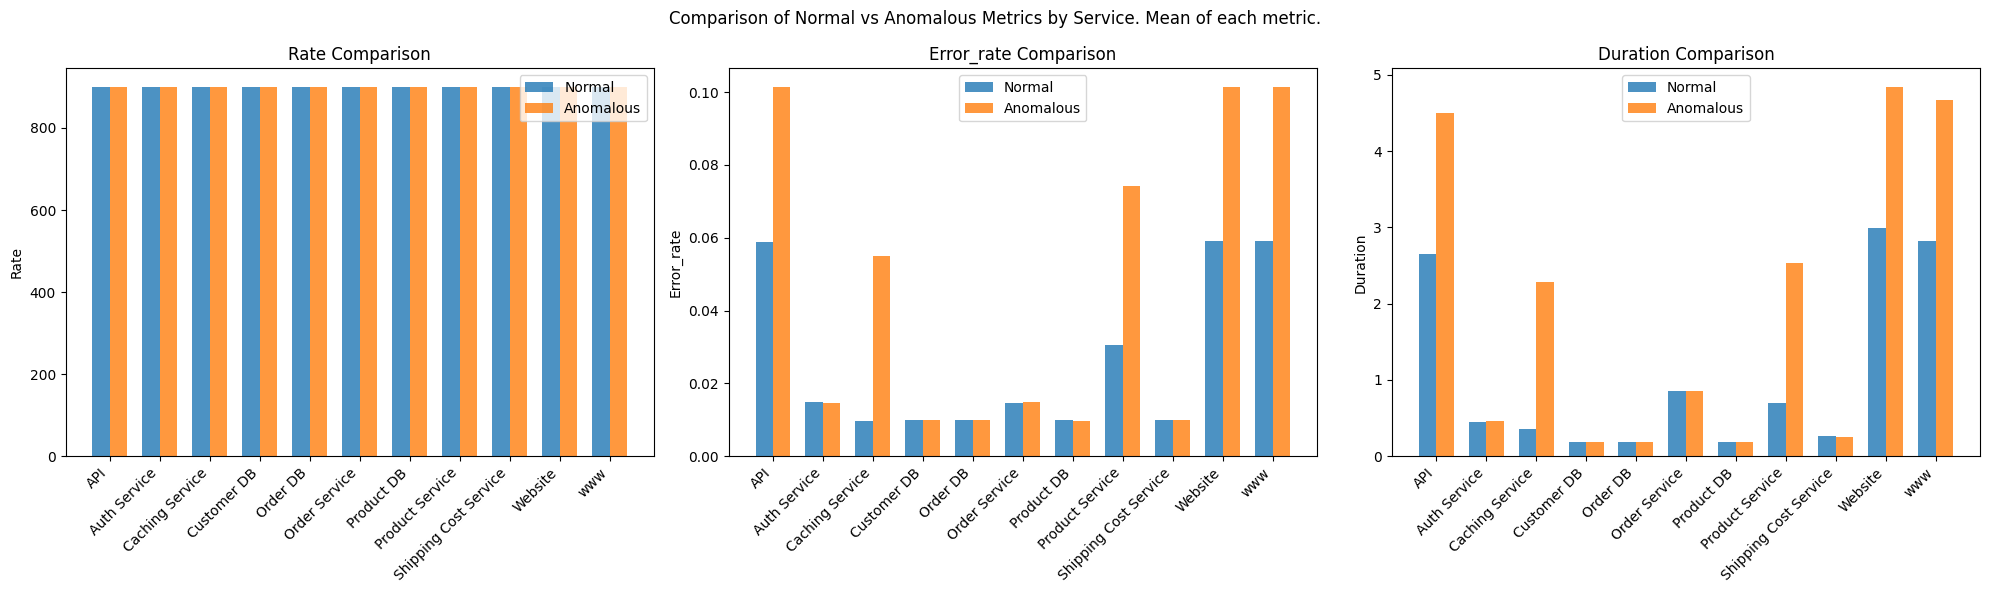

In [21]:
plot_normal_vs_anomalous_metrics(normal_data, anomalous_data)

### Alternative 1: Aggregate then attribute

*First, compute anomaly scores on each metric. Then aggregate them into a single one*

In [22]:
# Initialize the AnomalyAggregator with z_score method
aggregator = AnomalyAggregator(detection_method='z_score')

# Fit the detectors using the normal data
aggregator.fit_detectors(normal_data)

# Calculate anomaly scores for the anomalous data
normal_data_ascores  = aggregator.calculate_anomaly_scores(normal_data).pivot(index='time_index', columns='service', values='anomaly_score')
anomaly_data_ascores = aggregator.calculate_anomaly_scores(anomalous_data).pivot(index='time_index', columns='service', values='anomaly_score')

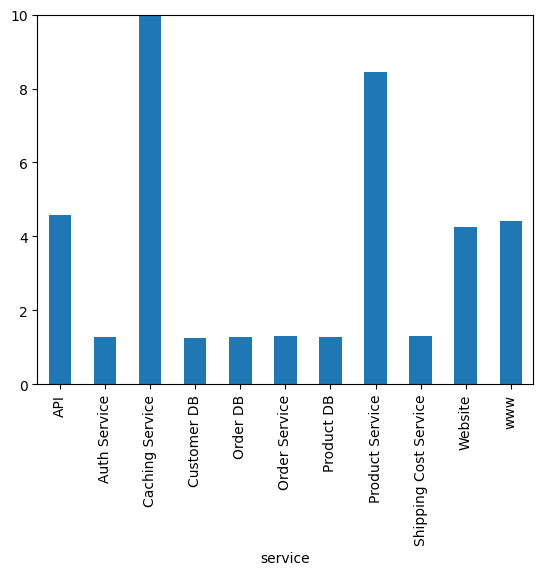

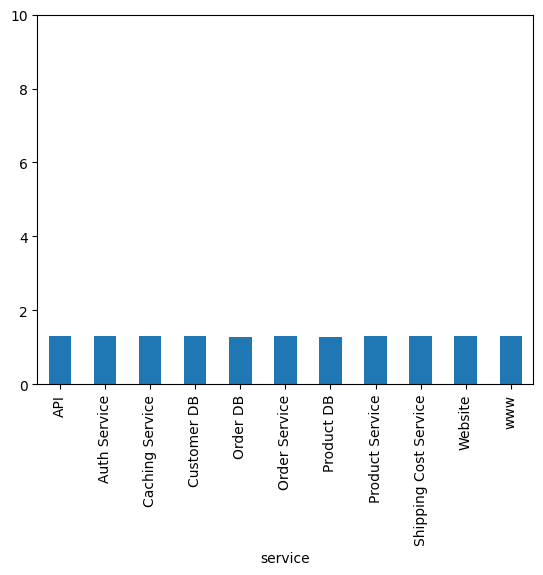

In [23]:
# Show mean anomaly scores
plt.figure()
ax = anomaly_data_ascores.mean().plot(kind='bar')
ax.set_ylim([0, 10])
plt.figure()
ax = normal_data_ascores.mean().plot(kind='bar')
ax.set_ylim([0, 10])

In [24]:
from causal_analyzer import CausalImpactAnalyzer
analyzer = CausalImpactAnalyzer()

In [25]:
target_node = 'Website'
causal_graph_path = "dummy_data/causal_graph.json"
with open(causal_graph_path, 'r') as f:
    causal_graph = nx.node_link_graph(json.load(f))

/Users/by-gc-ia/opt/anaconda3/envs/py-dowhy/lib/python3.11/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


Estimating Shapley Values. Average change of Shapley values in run 292 (1460 evaluated permutations): 1.5873414405120287%: 100%|██████████| 1/1 [00:06<00:00,  6.33s/it]
Estimating Shapley Values. Average change of Shapley values in run 656 (3280 evaluated permutations): 1.1976414405297882%: 100%|██████████| 1/1 [00:07<00:00,  7.15s/it]
Estimating Shapley Values. Average change of Shapley values in run 363 (1815 evaluated permutations): 1.3984808336964967%: 100%|██████████| 1/1 [00:06<00:00,  6.81s/it]
Estimating Shapley Values. Average change of Shapley values in run 498 (2490 evaluated permutations): 0.5429857554903711%: 100%|██████████| 1/1 [00:07<00:00,  7.22s/it]
Estimating bootstrap interval...: 100%|██████████| 4/4 [00:30<00:00,  7.60s/it]


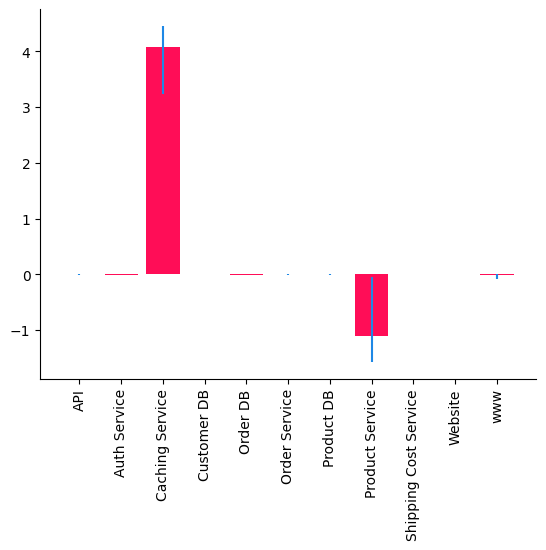

In [26]:
# Create an instance of the CausalImpactAnalyzer
analyzer = CausalImpactAnalyzer(discover_distributions=True, num_bootstrap_resamples=4)

# Load data and identify attributions
median_attribs, uncertainty_attribs = analyzer.identify_attributions(
    normal_data_ascores,
    anomaly_data_ascores, 
    causal_graph, 
    target_node
)

# Plot the attributions
plot_bytes = analyzer.plot_attributions(median_attribs, uncertainty_attribs)

Fitting causal mechanism of node Order DB: 100%|██████████| 11/11 [00:00<00:00, 1309.68it/s]  
Estimating Shapley Values. Average change of Shapley values in run 9 (45 evaluated permutations): 0.46178427118145043%: 100%|██████████| 1/1 [00:03<00:00,  3.52s/it]


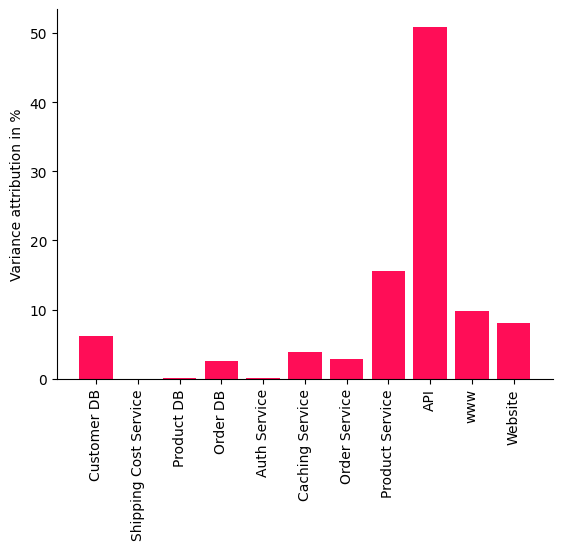

{'Customer DB': np.float64(0.06054223213961582),
 'Shipping Cost Service': np.float64(5.7258022587459273e-05),
 'Product DB': np.float64(0.0005261484138163048),
 'Order DB': np.float64(0.025241753212761144),
 'Auth Service': np.float64(0.0010553909110073505),
 'Caching Service': np.float64(0.03732746845546015),
 'Order Service': np.float64(0.027017198572507607),
 'Product Service': np.float64(0.1503535402044517),
 'API': np.float64(0.4928160784101016),
 'www': np.float64(0.09518812685693345),
 'Website': np.float64(0.07796985601519395)}

In [27]:
analyze_root_cause(anomaly_data_ascores, causal_graph, target_node)

### Alternative 2: Attribution per metric

In [58]:
# Filter metrics to ones that are anomalous (note: I put this lil hack in cause needa figure out how to account for non-anomalous metrics, here rate - which has no discernible difference with norm)

# Initialize the AnomalyAggregator with z_score method
aggregator = AnomalyAggregator(detection_method='z_score')

# Fit the detectors using the normal data
aggregator.fit_detectors(normal_data)

# Calculate anomaly scores for anomalous data
anomaly_data_ascores = aggregator.calculate_anomaly_scores(anomalous_data)

In [69]:
z_thresh = 2
agg_anomaly_ascores = anomaly_data_ascores.groupby('service')[['z_score_rate','z_score_error_rate','z_score_duration']].mean()
anomalous_service_metrics_df = agg_anomaly_ascores > z_thresh
anomalous_service_metrics_df

,z_score_rate,z_score_error_rate,z_score_duration
service,,,
API,False,True,True
Auth Service,False,False,False
Caching Service,False,True,True
Customer DB,False,False,False
Order DB,False,False,False
Order Service,False,False,False
Product DB,False,False,False
Product Service,False,True,True
Shipping Cost Service,False,False,False


In [81]:
anomalous_metrics_series = anomalous_service_metrics_df.any()
anomalous_metrics = anomalous_metrics_series[anomalous_metrics_series].index.tolist()
anomalous_metrics = [m.replace('z_score_', '') for m in anomalous_metrics]

In [82]:
# to do this with attribution per metric, we need to take the original dataframe and apply the analyzer to each metric individually
results = {}
for metric in anomalous_metrics:
    analyzer = CausalImpactAnalyzer(discover_distributions=True, 
                                    num_bootstrap_resamples=2)
    median_attribs, uncertainty_attribs = analyzer.identify_attributions(
        normal_data.pivot(index='time_index', columns='service', values=metric),
        anomalous_data.pivot(index='time_index', columns='service', values=metric), 
        causal_graph, 
        target_node
    )
    results[metric] = {
        'median_attribs': median_attribs,
        'uncertainty_attribs': uncertainty_attribs
    }

Estimating Shapley Values. Average change of Shapley values in run 162 (810 evaluated permutations): 1.4534405264537986%: 100%|██████████| 1/1 [00:07<00:00,  7.26s/it]
Estimating Shapley Values. Average change of Shapley values in run 444 (2220 evaluated permutations): 0.8241958910466246%: 100%|██████████| 1/1 [00:06<00:00,  6.80s/it]
Estimating bootstrap interval...: 100%|██████████| 2/2 [00:23<00:00, 11.81s/it]
Estimating Shapley Values. Average change of Shapley values in run 119 (595 evaluated permutations): 0.8294116516910416%: 100%|██████████| 1/1 [00:04<00:00,  4.43s/it]
Estimating Shapley Values. Average change of Shapley values in run 306 (1530 evaluated permutations): 1.5809436336991975%: 100%|██████████| 1/1 [00:06<00:00,  6.99s/it]
Estimating bootstrap interval...: 100%|██████████| 2/2 [00:12<00:00,  6.13s/it]


In [105]:
def compute_percent_contrib(results, metric):
    attribs_df = pd.DataFrame(results[metric])[['median_attribs']].abs()
    total_attribs_value = attribs_df['median_attribs'].sum()
    attribs_df['percent_contrib'] = attribs_df['median_attribs'] / total_attribs_value*100
    return attribs_df[['percent_contrib']]

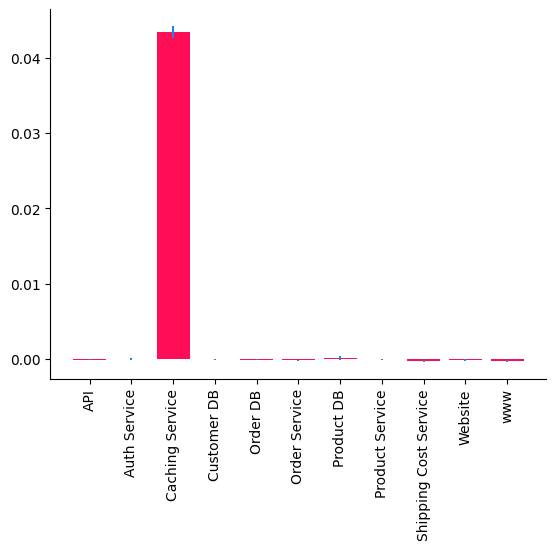

,percent_contrib
API,0.221298
Auth Service,0.054040
Caching Service,97.120334
Customer DB,0.119808
Order DB,0.205243
Order Service,0.440428
Product DB,0.224803
Product Service,0.067720
Shipping Cost Service,0.598946
Website,0.325336


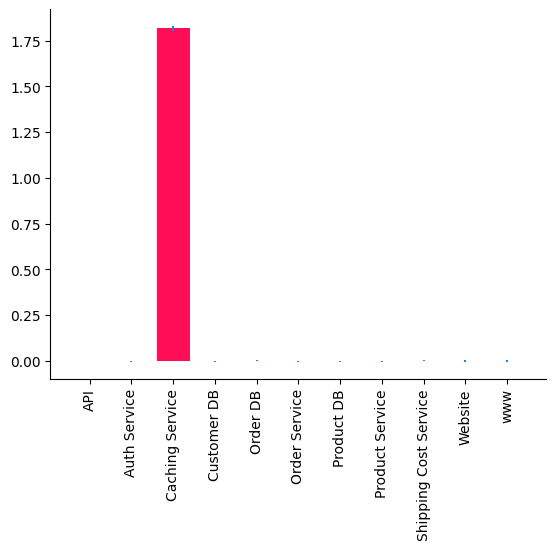

,percent_contrib
API,0.069233
Auth Service,0.141859
Caching Service,99.273536
Customer DB,0.109891
Order DB,0.037662
Order Service,0.114766
Product DB,0.054376
Product Service,0.087982
Shipping Cost Service,0.080974
Website,0.010096


In [106]:
contribution_floor = 20 # percent
# for each of these, plot the attributions
for metric in anomalous_metrics:
    plot_bytes = analyzer.plot_attributions(results[metric]['median_attribs'], results[metric]['uncertainty_attribs'])
    display(compute_percent_contrib(results, metric))